In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", message="A date index has been provided")
warnings.filterwarnings("ignore", message="No supported index is available")

# Set the precision to 5 decimal places
pd.set_option('display.precision', 5)
np.set_printoptions(precision=5)

# Define stock symbols
stock_symbols = ['AAPL', 'MSFT', 'XOM', 'JNJ', 'PG']

# Define the date range
start_date = '2015-01-01'
end_date = '2023-12-31'

# Download data for each stock symbol
prices = pd.DataFrame()

for symbol in stock_symbols:
    ticker = yf.Ticker(symbol)
    hist_data = ticker.history(start=start_date, end=end_date)
    prices[symbol] = hist_data['Close']

# Handling missing values
prices.interpolate(method='linear', inplace=True)
prices

,AAPL,MSFT,XOM,JNJ,PG
Date,,,,,
2015-01-02 00:00:00-05:00,24.28858,39.99870,58.96712,78.68142,67.44158
2015-01-05 00:00:00-05:00,23.60433,39.63087,57.35369,78.13187,67.12096
2015-01-06 00:00:00-05:00,23.60656,39.04921,57.04879,77.74797,66.81517
2015-01-07 00:00:00-05:00,23.93757,39.54533,57.62684,79.46430,67.16566
2015-01-08 00:00:00-05:00,24.85730,40.70869,58.58600,80.08910,67.93374
...,...,...,...,...,...
2023-12-22 00:00:00-05:00,192.19255,370.37573,96.78331,149.49269,140.01913
2023-12-26 00:00:00-05:00,191.64656,370.45483,97.00175,150.14659,140.65524
2023-12-27 00:00:00-05:00,191.74583,369.87149,96.54589,150.34854,140.77089


In [2]:
# Resample to month-end (ME) as per hint
monthly_prices = prices.resample('ME').last()

# Compute log returns on monthly data
monthly_log_returns = np.log(monthly_prices).diff().dropna()

# Ensure the index has frequency information ('ME' frequency)
monthly_log_returns.index = pd.DatetimeIndex(monthly_log_returns.index).to_period('M').to_timestamp('M')
monthly_prices.index = pd.DatetimeIndex(monthly_prices.index).to_period('M').to_timestamp('M')
monthly_prices

,AAPL,MSFT,XOM,JNJ,PG
Date,,,,,
2015-01-31,26.02808,34.55833,55.53060,75.38421,63.30254
2015-02-28,28.65110,37.77642,56.66538,77.70850,63.93339
2015-03-31,27.75227,35.02826,54.39981,76.26059,61.53769
2015-04-30,27.91286,41.90296,55.91659,75.19933,60.19303
2015-05-31,29.17840,40.63187,54.97878,76.46548,59.34511
...,...,...,...,...,...
2023-08-31,186.25882,323.42484,104.63960,154.23878,147.81808
2023-09-30,169.74170,311.57367,110.65317,148.58170,139.69643
2023-10-31,169.30548,333.63794,99.61420,141.51276,144.59714


In [3]:
def historical_mean_forecast(returns_history):
    """Simple historical mean forecast"""
    return returns_history.mean()

def arima_forecast(returns_history):
    """ARIMA(1,0,1) forecast for each asset with proper frequency handling"""
    forecasts = {}
    for asset in returns_history.columns:
        # Ensure the series has frequency information
        series = returns_history[asset].copy()
        
        try:
            # Using SARIMAX which provides more control over frequency handling
            model = SARIMAX(series, order=(1,0,1), freq='ME')
            model_fit = model.fit(disp=False)
            forecast = model_fit.forecast(steps=1)[0]
            forecasts[asset] = forecast
        except Exception as e:
            print(f"Error forecasting {asset}: {e}")
            # Fallback to historical mean in case of error
            forecasts[asset] = returns_history[asset].mean()
            
    return pd.Series(forecasts, index=returns_history.columns)

# Set up the rolling window for forecasting
train_window = 36  # 3 years of monthly data for initial training
test_start_idx = train_window
test_periods = len(monthly_log_returns) - train_window

# Initialize DataFrames to store forecasting results
forecast_results = {
    'Historical': pd.DataFrame(index=monthly_log_returns.index[test_start_idx:], columns=stock_symbols),
    'ARIMA': pd.DataFrame(index=monthly_log_returns.index[test_start_idx:], columns=stock_symbols)
}

actual_returns = monthly_log_returns.iloc[test_start_idx:].copy()

# Generate forecasts using rolling window
for i in range(test_periods):
    current_idx = test_start_idx + i
    forecast_date = monthly_log_returns.index[current_idx]
    
    # Get training data up to current point (excluding current month)
    train_data = monthly_log_returns.iloc[max(0, current_idx - train_window):current_idx]
    
    # Generate and store forecasts
    forecast_results['Historical'].loc[forecast_date] = historical_mean_forecast(train_data)
    forecast_results['ARIMA'].loc[forecast_date] = arima_forecast(train_data)

forecast_results

/var/folders/k1/7yl62fwx2879_758cjywcjrw0000gn/T/ipykernel_19144/3616487332.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast = model_fit.forecast(steps=1)[0]
/var/folders/k1/7yl62fwx2879_758cjywcjrw0000gn/T/ipykernel_19144/3616487332.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast = model_fit.forecast(steps=1)[0]
/var/folders/k1/7yl62fwx2879_758cjywcjrw0000gn/T/ipykernel_19144/3616487332.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value 

{'Historical':                AAPL     MSFT      XOM      JNJ       PG
 Date                                                   
 2018-02-28  0.01144  0.02587   0.0029  0.01124  0.00333
 2018-03-31  0.01061  0.02316 -0.00132  0.00886  0.00042
 2018-04-30  0.00983  0.02451 -0.00061  0.00901  0.00175
 2018-05-31  0.00925   0.0202 -0.00023  0.00903  0.00007
 2018-06-30  0.01154  0.02272  0.00174  0.00722  0.00078
 ...             ...      ...      ...      ...      ...
 2023-08-31  0.01758  0.01448  0.03038  0.00606  0.00693
 2023-09-30  0.01093  0.01114  0.03252  0.00367  0.00509
 2023-10-31  0.01136  0.01204  0.03828  0.00347  0.00339
 2023-11-30    0.013    0.015  0.03678   0.0044  0.00457
 2023-12-31  0.01346   0.0166   0.0312   0.0041  0.00485
 
 [71 rows x 5 columns],
 'ARIMA':                AAPL     MSFT      XOM      JNJ       PG
 Date                                                   
 2018-02-28  0.00111 -0.02598  0.00454  0.00854  0.00747
 2018-03-31 -0.00909   0.0049  0.00801 

In [4]:
# Evaluate forecasting performance
forecast_performance = {}

for model_name, forecasts in forecast_results.items():
    # Calculate RMSE and MAE for each asset
    asset_metrics = {}
    for asset in stock_symbols:
        rmse = np.sqrt(mean_squared_error(actual_returns[asset], forecasts[asset]))
        mae = mean_absolute_error(actual_returns[asset], forecasts[asset])
        
        # Directional accuracy
        correct_direction = np.sum((actual_returns[asset] > 0) == (forecasts[asset] > 0))
        directional_accuracy = correct_direction / len(actual_returns)
        
        asset_metrics[asset] = {
            'RMSE': rmse,
            'MAE': mae,
            'Dir. Accuracy': directional_accuracy
        }
    
    # Overall metrics
    overall_rmse = np.sqrt(mean_squared_error(actual_returns.values.flatten(), forecasts.values.flatten()))
    overall_mae = mean_absolute_error(actual_returns.values.flatten(), forecasts.values.flatten())
    
    # Overall directional accuracy
    correct_dir = np.sum(np.sum((actual_returns > 0) == (forecasts > 0)))
    total_preds = actual_returns.size
    overall_dir_acc = correct_dir / total_preds
    
    forecast_performance[model_name] = {
        'Asset Metrics': asset_metrics,
        'Overall': {
            'RMSE': overall_rmse,
            'MAE': overall_mae,
            'Dir. Accuracy': overall_dir_acc
        }
    }

forecast_performance

/Users/ch0002techvc/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/ch0002techvc/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


{'Historical': {'Asset Metrics': {'AAPL': {'RMSE': np.float64(0.08912713845640027),
    'MAE': 0.07488240199215768,
    'Dir. Accuracy': np.float64(0.5915492957746479)},
   'MSFT': {'RMSE': np.float64(0.06139595824382312),
    'MAE': 0.049619967603241964,
    'Dir. Accuracy': np.float64(0.6338028169014085)},
   'XOM': {'RMSE': np.float64(0.09724603008493111),
    'MAE': 0.07285796277017953,
    'Dir. Accuracy': np.float64(0.4788732394366197)},
   'JNJ': {'RMSE': np.float64(0.05074166449053809),
    'MAE': 0.04005394644302195,
    'Dir. Accuracy': np.float64(0.5774647887323944)},
   'PG': {'RMSE': np.float64(0.051451250814880306),
    'MAE': 0.042291912020532584,
    'Dir. Accuracy': np.float64(0.6197183098591549)}},
  'Overall': {'RMSE': np.float64(0.072652389624938),
   'MAE': 0.05594123816582675,
   'Dir. Accuracy': np.float64(0.5802816901408451)}},
 'ARIMA': {'Asset Metrics': {'AAPL': {'RMSE': np.float64(0.09179509512128724),
    'MAE': 0.07680983643840862,
    'Dir. Accuracy': np.f

In [5]:
def mean_variance_optimization(expected_returns, cov_matrix, risk_free_rate=0.01/12):
    """
    Perform mean-variance optimization to maximize Sharpe ratio
    """
    n_assets = len(expected_returns)
    
    def objective(weights):
        portfolio_return = np.sum(weights * expected_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        
        # Avoid division by zero
        if portfolio_volatility == 0:
            return -999  # Large negative number to avoid this solution
            
        sharpe = (portfolio_return - risk_free_rate) / portfolio_volatility
        return -sharpe  # Minimize negative Sharpe ratio
    
    # Constraints: weights sum to 1
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    
    # Bounds: no short selling
    bounds = tuple((0, 1) for _ in range(n_assets))
    
    # Initial guess: equal weights
    initial_weights = np.ones(n_assets) / n_assets
    
    # Optimize
    try:
        result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
        if not result.success:
            return initial_weights
        return result.x
    except Exception:
        return initial_weights

def minimum_variance_portfolio(cov_matrix):
    """
    Construct a minimum variance portfolio
    """
    n_assets = cov_matrix.shape[0]
    
    def objective(weights):
        return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    # Constraints: weights sum to 1
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    
    # Bounds: no short selling
    bounds = tuple((0, 1) for _ in range(n_assets))
    
    # Initial guess: equal weights
    initial_weights = np.ones(n_assets) / n_assets
    
    # Optimize
    try:
        result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
        if not result.success:
            return initial_weights
        return result.x
    except Exception:
        return initial_weights

# Equal Weight Portfolio
weights = np.ones(len(stock_symbols)) / len(stock_symbols)

# Initialize dictionaries to store portfolio results
portfolio_values = {
    'Mean-Variance (Historical)': pd.Series(index=monthly_log_returns.index[test_start_idx:]),
    'Mean-Variance (ARIMA)': pd.Series(index=monthly_log_returns.index[test_start_idx:]),
    'Minimum Variance': pd.Series(index=monthly_log_returns.index[test_start_idx:]),
    'Equal Weight': pd.Series(index=monthly_log_returns.index[test_start_idx:])
}

portfolio_weights = {
    'Mean-Variance (Historical)': pd.DataFrame(index=monthly_log_returns.index[test_start_idx:], columns=stock_symbols),
    'Mean-Variance (ARIMA)': pd.DataFrame(index=monthly_log_returns.index[test_start_idx:], columns=stock_symbols),
    'Minimum Variance': pd.DataFrame(index=monthly_log_returns.index[test_start_idx:], columns=stock_symbols),
    'Equal Weight': pd.DataFrame(index=monthly_log_returns.index[test_start_idx:], columns=stock_symbols)
}

# Set initial portfolio value
initial_value = 10000
portfolio_values_prev = {strategy: initial_value for strategy in portfolio_values}

# Implement monthly rebalancing
for i in range(test_periods):
    current_idx = test_start_idx + i
    current_date = monthly_log_returns.index[current_idx]
    
    # Skip the last period since we don't have next month's returns
    if current_idx >= len(monthly_log_returns) - 1:
        continue
    
    next_idx = current_idx + 1
    next_date = monthly_log_returns.index[next_idx]
    
    # Calculate covariance matrix using historical data
    lookback = 24  # 2 years of monthly data
    start_idx = max(0, current_idx - lookback)
    cov_lookback = monthly_log_returns.iloc[start_idx:current_idx]
    cov_matrix = cov_lookback.cov().values
    
    # Get expected returns from our forecasting models
    hist_expected_returns = forecast_results['Historical'].loc[current_date].values
    arima_expected_returns = forecast_results['ARIMA'].loc[current_date].values
    
    # Strategy 1: Mean-Variance using Historical forecasts
    weights = mean_variance_optimization(hist_expected_returns, cov_matrix)
    portfolio_weights['Mean-Variance (Historical)'].loc[current_date] = weights
    
    # Strategy 2: Mean-Variance using ARIMA forecasts
    weights = mean_variance_optimization(arima_expected_returns, cov_matrix)
    portfolio_weights['Mean-Variance (ARIMA)'].loc[current_date] = weights
    
    # Strategy 3: Minimum Variance Portfolio
    weights = minimum_variance_portfolio(cov_matrix)
    portfolio_weights['Minimum Variance'].loc[current_date] = weights
    
    # Strategy 4: Equal Weight Portfolio
    weights = np.ones(len(stock_symbols)) / len(stock_symbols)
    portfolio_weights['Equal Weight'].loc[current_date] = weights
    
    # Get actual returns for the next month
    actual_next_returns = monthly_log_returns.iloc[next_idx].values
    
    # Update portfolio values based on actual returns
    for strategy in portfolio_values:
        strategy_weights = portfolio_weights[strategy].loc[current_date].values
        portfolio_return = np.sum(strategy_weights * actual_next_returns)
        portfolio_values[strategy].loc[current_date] = portfolio_values_prev[strategy]
        portfolio_values_prev[strategy] = portfolio_values_prev[strategy] * (1 + portfolio_return)

def calculate_performance_metrics(returns):
    """Calculate key portfolio performance metrics"""
    if returns.std() == 0:
        return {
            'Annual Return': returns.mean() * 12,
            'Annual Volatility': 0,
            'Sharpe Ratio': 0,
            'Maximum Drawdown': 0,
            'Total Return': returns.sum() * 12
        }
    
    # Annualized metrics
    annual_return = returns.mean() * 12
    annual_vol = returns.std() * np.sqrt(12)
    sharpe_ratio = annual_return / annual_vol
    
    # Cumulative return
    cum_return = (1 + returns).prod() - 1
    
    # Maximum drawdown
    cum_returns = (1 + returns).cumprod()
    running_max = cum_returns.cummax()
    drawdowns = (cum_returns / running_max) - 1
    max_drawdown = drawdowns.min()
    
    return {
        'Annual Return': annual_return,
        'Annual Volatility': annual_vol,
        'Sharpe Ratio': sharpe_ratio,
        'Maximum Drawdown': max_drawdown,
        'Cumulative Return': cum_return
    }

portfolio_performance = {}

for strategy, values in portfolio_values.items():
    # Calculate returns from portfolio values
    strategy_returns = values.pct_change().dropna()
    portfolio_performance[strategy] = calculate_performance_metrics(strategy_returns)

portfolio_performance

/var/folders/k1/7yl62fwx2879_758cjywcjrw0000gn/T/ipykernel_19144/3764630047.py:170: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  strategy_returns = values.pct_change().dropna()


{'Mean-Variance (Historical)': {'Annual Return': np.float64(0.16965976123084478),
  'Annual Volatility': np.float64(0.17876824857086746),
  'Sharpe Ratio': np.float64(0.9490486290891199),
  'Maximum Drawdown': np.float64(-0.2563004456636111),
  'Cumulative Return': np.float64(1.4425421974530068)},
 'Mean-Variance (ARIMA)': {'Annual Return': np.float64(0.1792139914964989),
  'Annual Volatility': np.float64(0.23751366274945782),
  'Sharpe Ratio': np.float64(0.7545418205501022),
  'Maximum Drawdown': np.float64(-0.3585377290976193),
  'Cumulative Return': np.float64(1.3804908039889892)},
 'Minimum Variance': {'Annual Return': np.float64(0.1531060672969384),
  'Annual Volatility': np.float64(0.15109353246824858),
  'Sharpe Ratio': np.float64(1.01331979467164),
  'Maximum Drawdown': np.float64(-0.1700263731307048),
  'Cumulative Return': np.float64(1.2771558296435312)},
 'Equal Weight': {'Annual Return': np.float64(0.16143830248637459),
  'Annual Volatility': np.float64(0.16915130662782016)

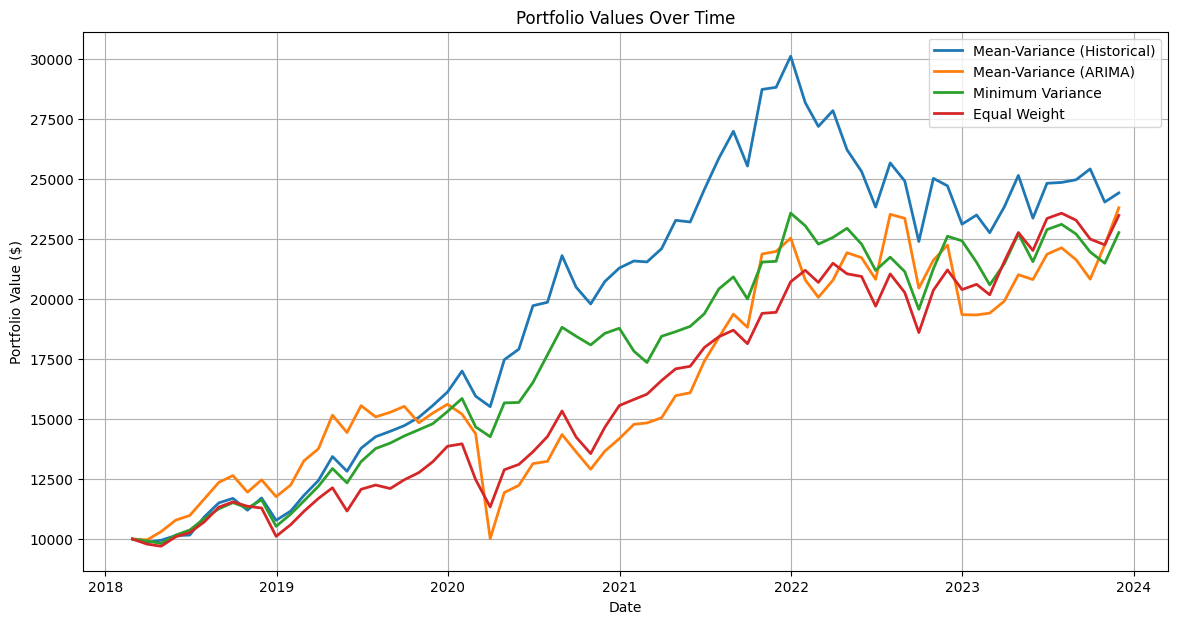

In [6]:
# Visualize portfolio values over time
plt.figure(figsize=(14, 7))
for strategy, values in portfolio_values.items():
    plt.plot(values.index, values, linewidth=2, label=strategy)
plt.title("Portfolio Values Over Time")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.show()

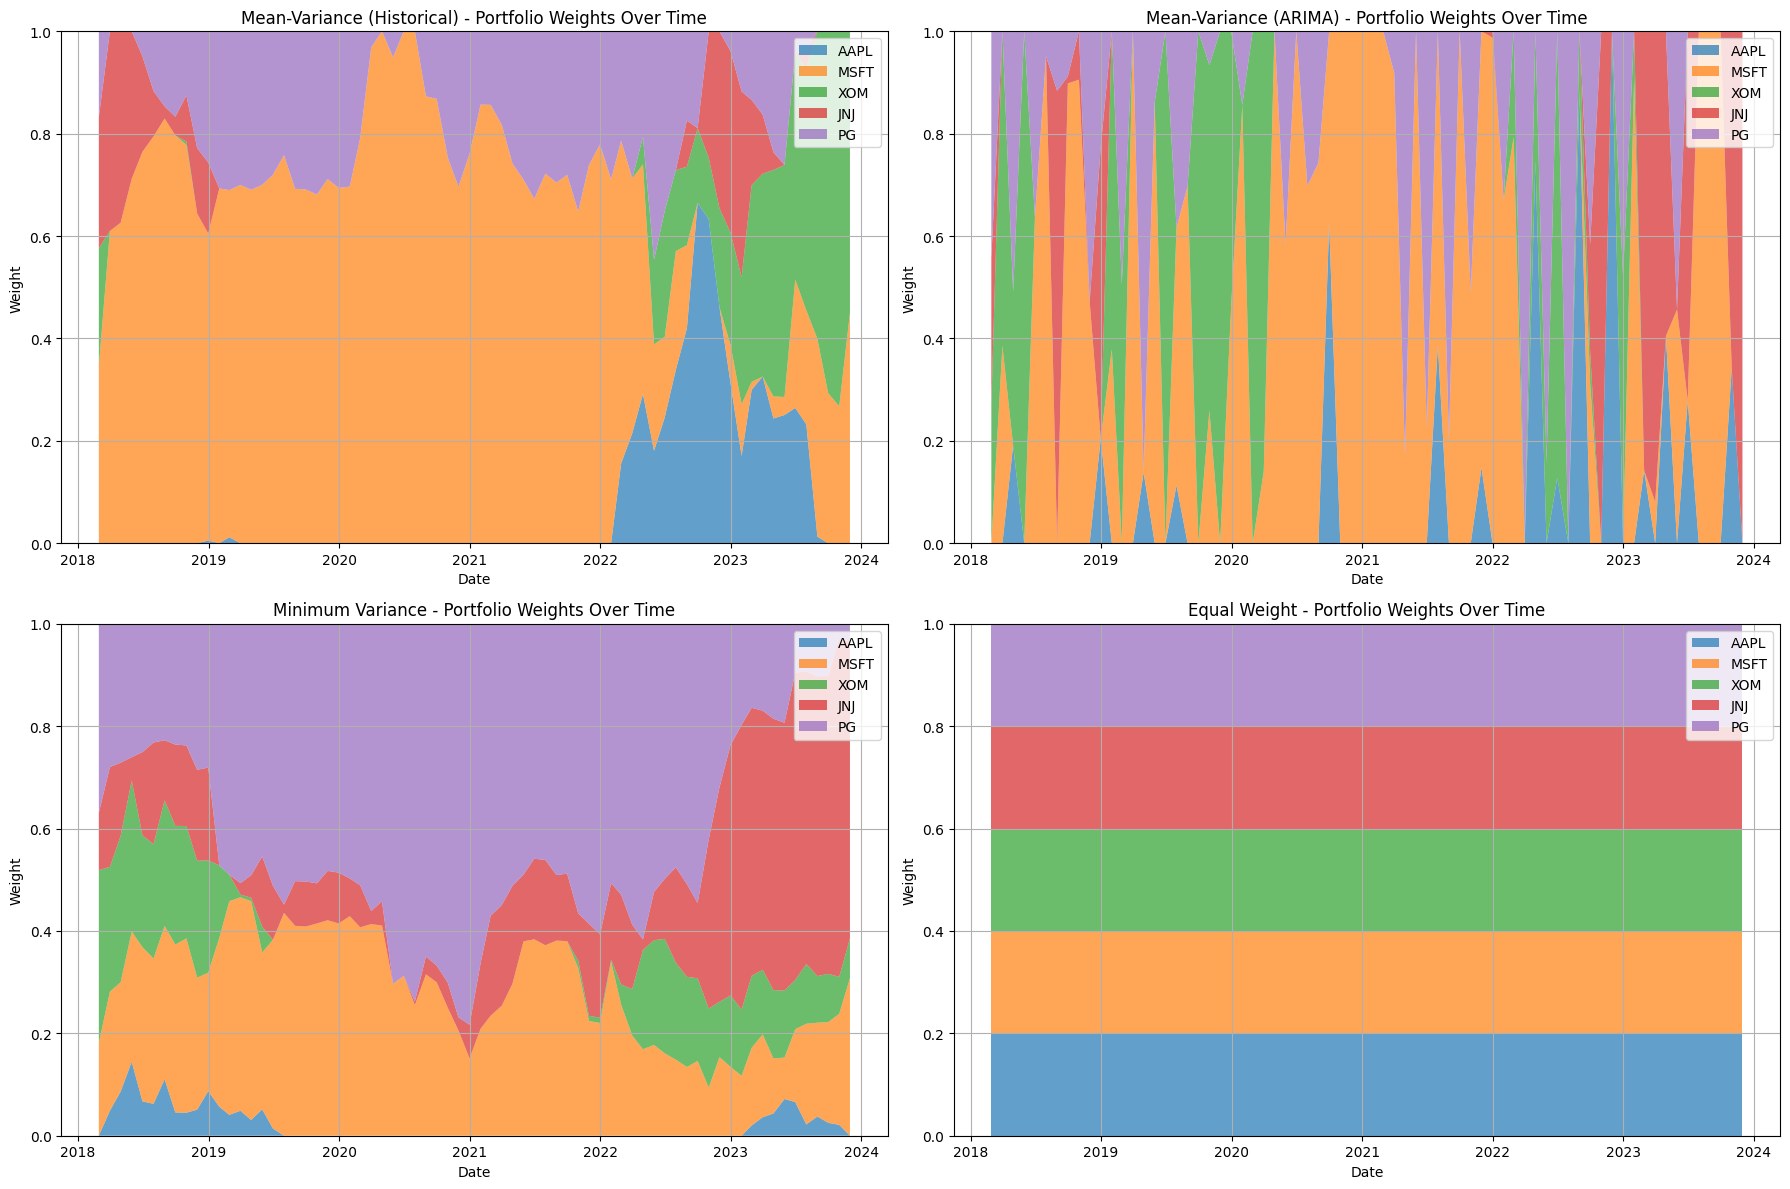

In [7]:
# Visualize portfolio weights over time
plt.figure(figsize=(18, 12))
for i, (strategy, weights) in enumerate(portfolio_weights.items()):
    plt.subplot(2, 2, i+1)
    weights_plot = weights.dropna()
    
    # Convert to float and ensure numeric types [1][7][11]
    weights_plot = weights_plot.astype(float)
    
    # Plot stacked area chart for weights
    plt.stackplot(weights_plot.index, 
                 [weights_plot[col].values for col in weights_plot.columns],  # Use .values to get numpy array
                 labels=weights_plot.columns, 
                 alpha=0.7)
    
    plt.title(f"{strategy} - Portfolio Weights Over Time")
    plt.xlabel("Date")
    plt.ylabel("Weight")
    plt.ylim(0, 1)
    plt.legend(loc='upper right')
    plt.grid(True)
plt.tight_layout()
plt.show()